In [1]:
# Install helmet-assignment helper code
# !pip install input/helmet-assignment-helpers/helmet-assignment-main/ > /dev/null 2>&1
from helmet_assignment.score import NFLAssignmentScorer, check_submission
from helmet_assignment.features import add_track_features

import numpy as np
import pandas as pd
import glob
import os
import cv2
import itertools
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random
random.seed(42)
from matplotlib.pyplot import figure

import sys
sys.path.append('input/easydict-master/easydict-master/')
# https://github.com/mikel-brostrom/Yolov5_DeepSort_Pytorch
sys.path.append('input/yolov5-deepsort-pytorch/Yolov5_DeepSort_Pytorch-master/Yolov5_DeepSort_Pytorch-master/deep_sort_pytorch/')
from deep_sort.deep_sort import DeepSort
from utils.parser import get_config
from helmet_assignment.video import video_with_predictions
from IPython.display import Video, display


# process_with_posit

In [ ]:

def find_nearest(array, value): # находит значение ближайшего est_frame-а к value (фрэйму)
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin() # из номеров est_frame вычитаем frame, берем модуль. Находим индекс минимального элемента в массиве
    return array[idx] # значение ближайшего est_frame-а

def modern_posit(image_pts, world_pts, focal_length, center):
    nb_points = np.shape(image_pts)[0]

    # centered & scaled pixel coordinates
    centered_image = np.divide(np.subtract(image_pts, center), focal_length)
    ui = centered_image[:, 0]
    vi = centered_image[:, 1]

    # homogeneous world coordinates
    homogeneous_world_pts = np.append(world_pts, np.ones((nb_points, 1)), 1)

    # pseudo inverse
    object_mat = np.linalg.pinv(homogeneous_world_pts)
    #print(object_mat)

    converged = 0
    count = 0
    t_x = 0.0
    t_y = 0.0
    t_z = 0.0
    r1 = 0.0
    r2 = 0.0
    r3 = 0.0
    while converged == 0:
        # POS part of the algorithm
        # rotation vectors
        r1_t = np.matmul(object_mat, ui)
        r2_t = np.matmul(object_mat, vi)
        # 1/t_z1 is norm of r1_t
        t_z1 = 1 / np.linalg.norm(r1_t[0:3])
        # 1/tz_2 is norm of r2_t
        t_z2 = 1 / np.linalg.norm(r2_t[0:3])
        
        # geometric average
        t_z = np.sqrt(t_z1 * t_z2)
        
        r1_n = np.multiply(r1_t, t_z)
        r2_n = np.multiply(r2_t, t_z)
        r1 = r1_n[0:3]
        r2 = r2_n[0:3]
        r3 = np.cross(r1, r2)
        r3_t = np.append(r3, t_z)
        t_x = r1_n[3]
        t_y = r2_n[3]

        # Now update the z/T z or epsilon
        # then ui, vi
        epsilon_i = np.matmul(homogeneous_world_pts, np.divide(r3_t, t_z))
        old_ui = ui
        old_vi = vi
        ui = np.multiply(epsilon_i, centered_image[:, 0])
        vi = np.multiply(epsilon_i, centered_image[:, 1])

        # check for convergence
        delta_ui = ui - old_ui
        delta_vi = vi - old_vi
        delta = np.square(focal_length) * (np.square(np.linalg.norm(delta_ui)) + np.square(np.linalg.norm(delta_vi)))

        converged = 1 if count > 0 and delta < 1 else 0
        count = count + 1

    trans = np.array([t_x, t_y, t_z], np.float64)
    rot = np.array([r1, r2, r3], np.float64)
    return rot, trans


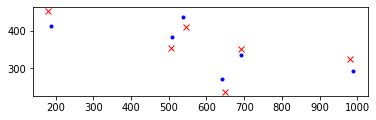

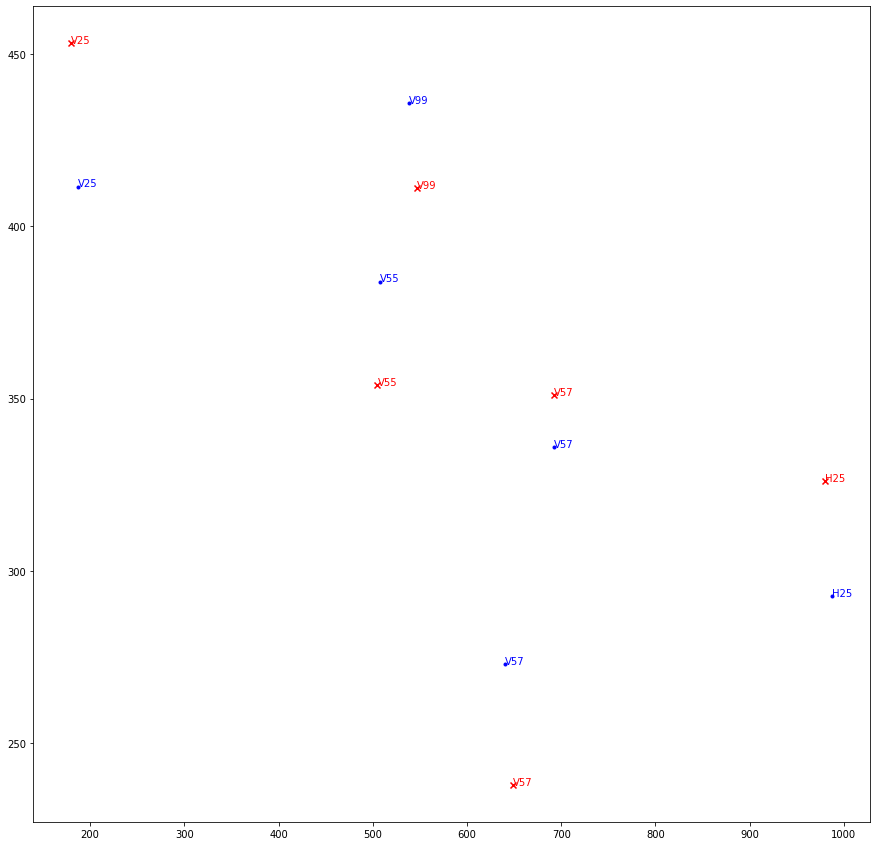

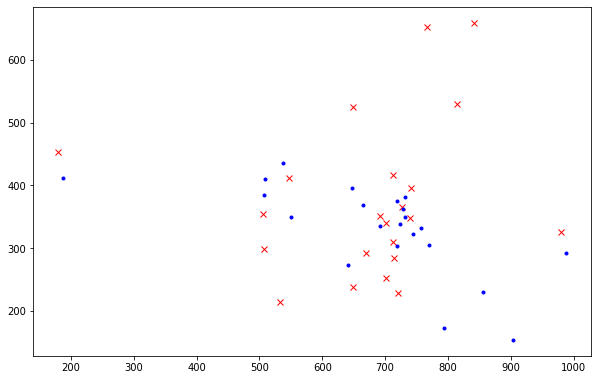

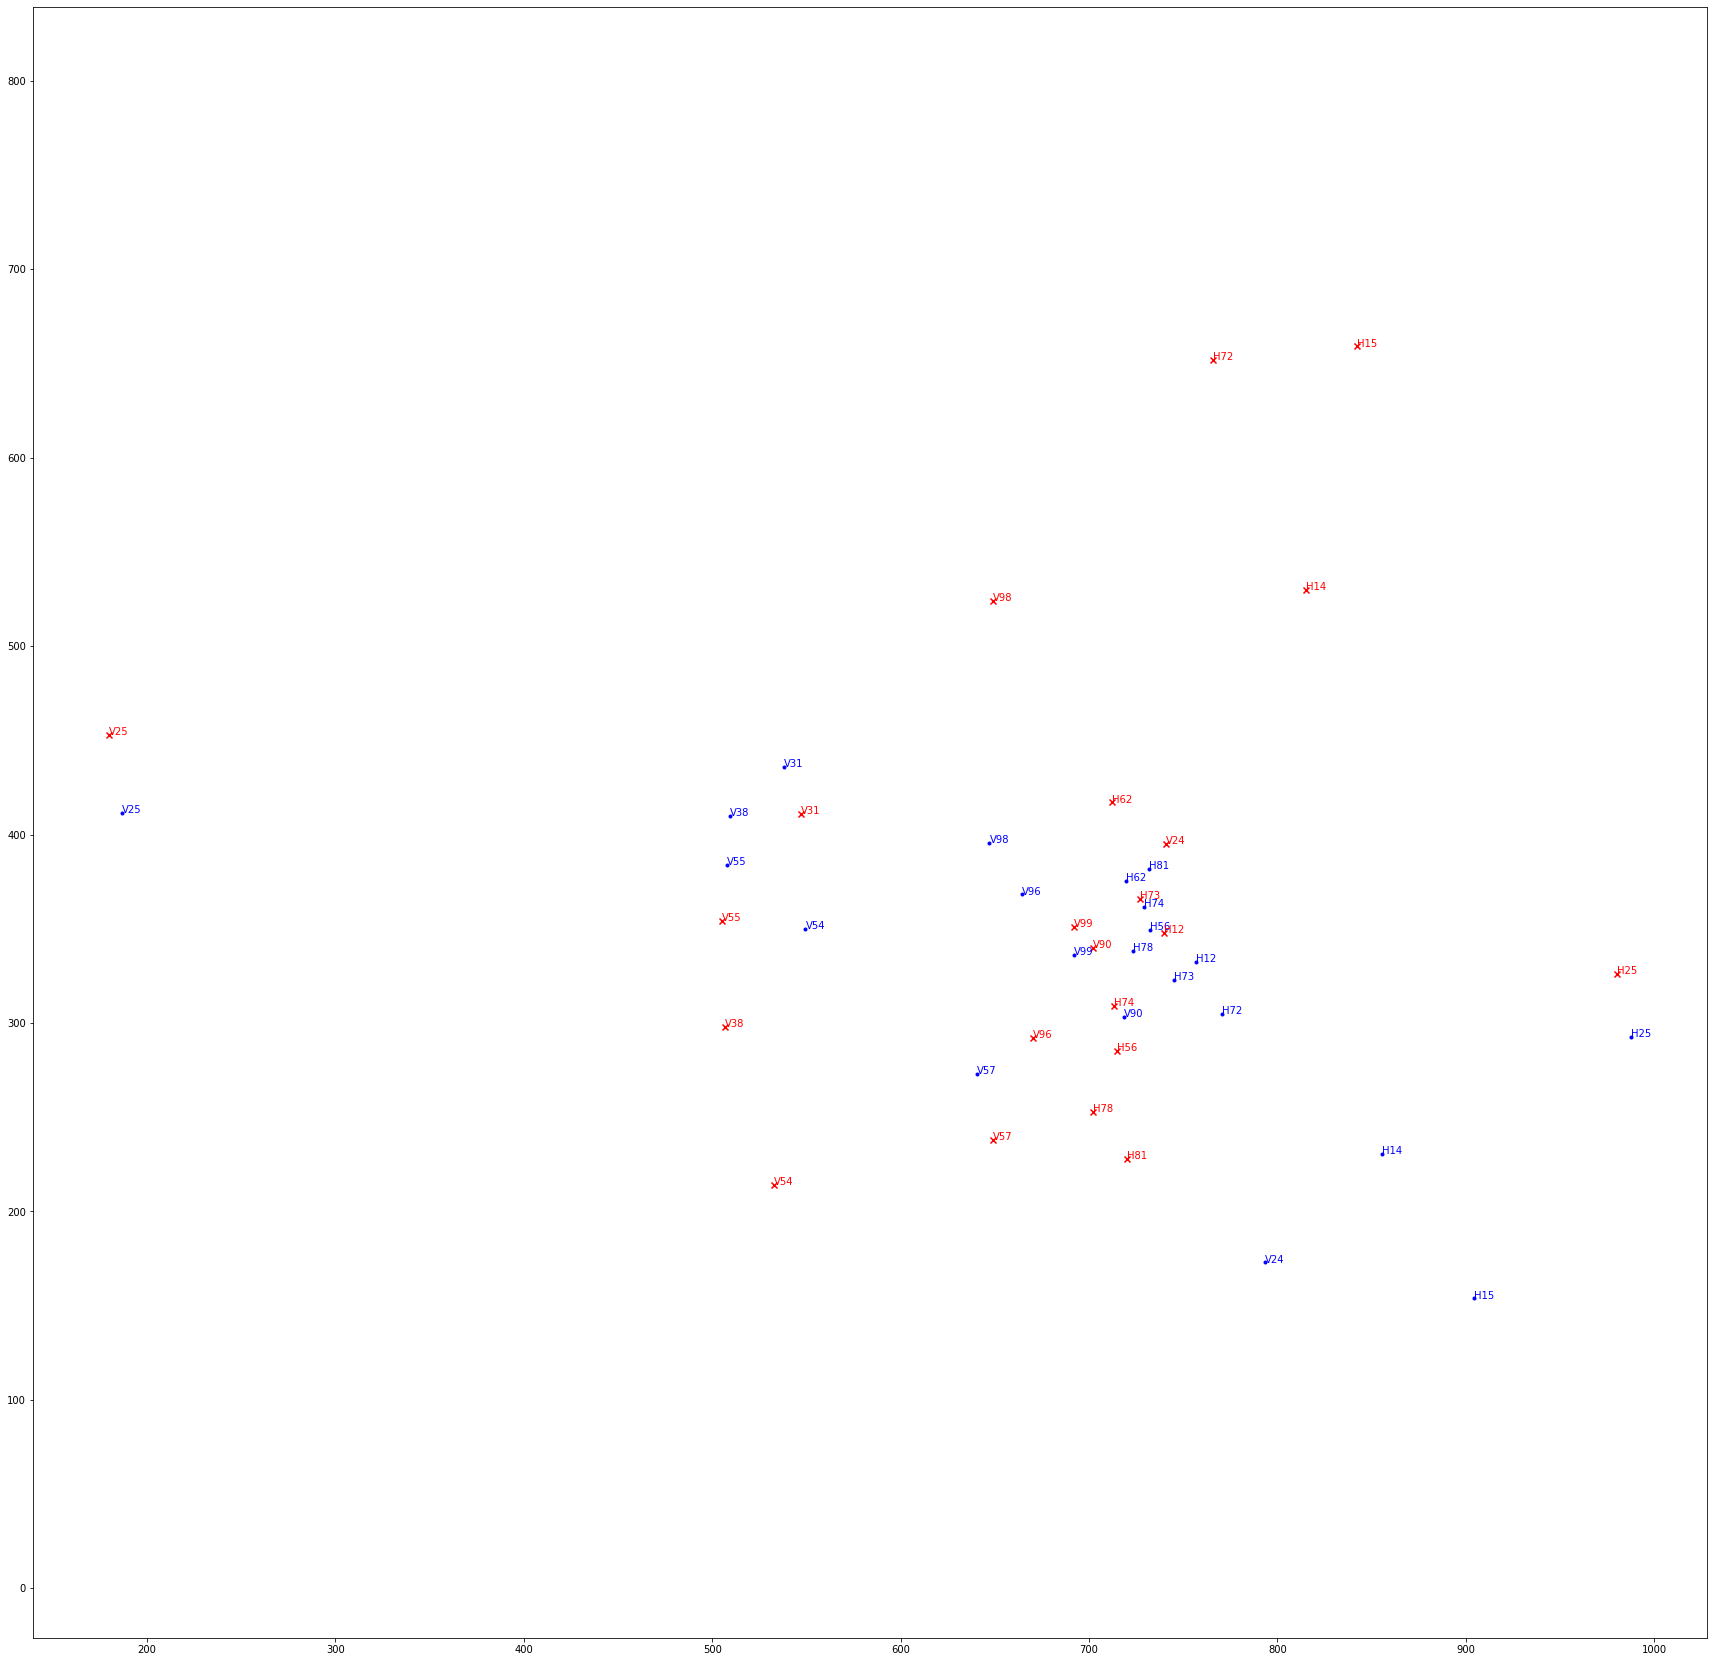

In [13]:
out = pd.read_csv('tstr/out.csv')
tracking_gp = pd.read_csv('tstr/tracking_gp.csv')

tracking = tracking_gp

'''
IN: результаты дипсорта с самым частым лэйблом и его значением, а также трекинг

'''
# print('out\n',out)
# print('tracking\n',tracking)
PLOT = True

track_confidence = {}
for cluster in out['deepsort_cluster'].unique(): # Пробегаемся по кластерам дипсорта
    if not np.isnan(cluster): # Если кластер не None, то есть после пропускаемых дипсортом кадров
        label_count = out[out['deepsort_cluster'] == cluster]['label_count_deepsort'].unique()[0] # количество появлений топ кластера
        num_frames = len(out[out['deepsort_cluster'] == cluster]) # число кадров
        track_confidence[cluster] = label_count/num_frames # как часто кластер появляется на кадре. Словарь Кластер:Частота

out['track_confidence'] = out['deepsort_cluster'].map(track_confidence) # Добавляем столбец с conf трека
outs_posit = []
errors = []
for f in [5]:#(1, out['frame'].max()+1): # пробегаемся по кадрам                
    # результаты дипсорта сортируем по conf кластера из первого цикла и берем топ7 по conf
    out_posit = out[out['frame'] == f].sort_values(['track_confidence'], ascending=False).copy() 
    out_posit_confident = out_posit.head(7).copy() 
    
    # находим в треке примерный кадр и фиксируем его трек
    nearest_frame_tracking = find_nearest(tracking['est_frame'].values, f) # int номер кадра
    tracking_posit = tracking[tracking['est_frame']==nearest_frame_tracking].copy() # трек этого кадра

    # Если игрок входит в  Топ7 из кластеров дипсорта по conf 
    tracking_posit_confident = tracking_posit[tracking_posit['player'].isin(out_posit_confident['label_deepsort'].values)].copy()
    tracking_posit_confident['label_posit'] = tracking_posit_confident['player'].copy() # лейбл игрока
    
    # Находим дипсорт лэйблы у которых больше одного шлема и складываем в out_posit_confident_duplicates 
    out_posit_confident['label_posit'] = out_posit_confident['label_deepsort'].copy() # лейбл посита делаем из лейбла дипсорта
    out_posit_confident_duplicates = out_posit_confident['label_deepsort'].value_counts() # считаем количество значений лэйблов дипсорта
    out_posit_confident_duplicates = out_posit_confident_duplicates[out_posit_confident_duplicates > 1] # если больше 1 то складываем в датафрейм

    # Разбираемся с дубликатами 
    dupl_label = "" # заглушка для дублируемого лэйбла
    dupl_label_list = list(out_posit_confident_duplicates.to_dict().keys()) # делаем словарь (список?) из 2+ встречающихся лэйблов дипсорта
    if len(dupl_label_list) > 0: # список длинный
        dupl_label = dupl_label_list[0] # оставляем первый лэйбл из списка

    # Для 7 уверенных кластеров (лейблов) проставляем координаты из трека
    out_posit_confident_merged = out_posit_confident.merge(tracking_posit_confident, on='label_posit', 
                                                           suffixes = ['','_t'])[['video_frame', 'label_posit', 'x', 'y', 'x_t', 'y_t']].copy()

    # По сути дубликат 7 уверенных шлемов дипсорта
    to_find_index = out_posit_confident.reset_index(drop=True).copy()

    # Делаем двухмерные координаты из координат центров боксов. Трехмерные из координат трека плюс дополнительная зануленная координата
    points_2d = np.array([out_posit_confident_merged['x'].values, 720-out_posit_confident_merged['y'].values]).transpose()
    points_3d = np.array([out_posit_confident_merged['x_t'].values, out_posit_confident_merged['y_t'].values]).transpose()
    points_3d = np.append(points_3d, np.zeros((points_3d.shape[0], 1)), axis=1)

    num_of_entries = len(points_2d) # Количество шлемов в датафрейме из 7 топ шлемов (наверное их всегда <=7?)
    # Находим список индексы где находится дубликат dupl_label 
    dupl_list = to_find_index.index[to_find_index['label_deepsort'] == dupl_label].tolist()
    
    best_error = float("inf")
    best_matrix = None
    best_projected_points_2d_homogen = None
    # Если есть дубликаты в столбце label_deepsort, то сначала убираем дубликаты и потом Posit
    if (len(out_posit_confident['label_deepsort']) - len(out_posit_confident['label_deepsort'].unique()) == 1):
        for idx in dupl_list: # итерируемся по индексам дубликатов
            # Делаем двухмерные координаты из координат центров боксов. Трехмерные из координат трека плюс дополнительная зануленная координата
            points_2d = np.array([out_posit_confident_merged['x'].values, 720-out_posit_confident_merged['y'].values]).transpose() # (6,2)
            points_3d = np.array([out_posit_confident_merged['x_t'].values, out_posit_confident_merged['y_t'].values]).transpose() # (6,2)
            points_3d = np.append(points_3d, np.zeros((points_3d.shape[0], 1)), axis=1) # (6,3)

            # выкидываем из 7 шлемов дублирующий
            good_indices = list(range(num_of_entries))  # [0, 1, 2, 3, 4, 6]
            good_indices.pop(idx) # выкидываем итериуемый индекс
            points_2d = np.array([points_2d[i] for i in good_indices])
            points_3d = np.array([points_3d[i] for i in good_indices])

            # Posit
            #rot, trans = modern_posit(points_2d[indexes], points_3d[indexes], 1920, [640, 360])
            rot, trans = modern_posit(points_2d, points_3d, 1920, [640, 360]) # получаем матрицу поворота и перемещения
            rottrans = np.append(rot, trans.reshape(3,1), axis=1) # объединяем их в одну (3,4)
            
            intrin = np.array([
                [1920, 0, 640],
                [0, 1920, 360],
                [0, 0, 1],])
            full_matrix = np.matmul(intrin, rottrans) # применяем матрицу поворот+перемещение (векторное произведение)

            # Векторное произведение full_matrix и трехмерныых координат трека с добавленным столбцом единиц. Результат (3,6)
            # Берем трехмерные координаты трека points_3d (6,3) (с добавленной нулевой третьей осью) # добавляем единичный столбец (6,4) и транспонируем
            projected_points_2d = np.matmul(full_matrix, np.transpose(np.append(points_3d, np.ones((points_3d.shape[0], 1)), axis=1)))

            projected_points_2d_t = np.transpose(projected_points_2d) # транспонируем (6,3)
            # Происходит магия, на выходе (6,3)
            projected_points_2d_homogen = projected_points_2d_t / projected_points_2d[2].reshape(points_3d.shape[0],1)
            
            # Считаем ошибку и если она меньше предыдущей минимальной (или бесконечности в начале), то фиксируем norm_error, full_matrix, projected_points_2d_homogen
            norm_error = np.linalg.norm(points_2d - projected_points_2d_homogen[:,0:2])
            if norm_error < best_error:
                best_error = norm_error
                best_matrix = full_matrix
                best_projected_points_2d_homogen = projected_points_2d_homogen
        # После того как проитерировали все индексы дубликатов, фиксируем norm_error, full_matrix, projected_points_2d_homogen из варианта с минимальной ошибкой
        norm_error = best_error
        full_matrix = best_matrix
        projected_points_2d_homogen = best_projected_points_2d_homogen
    # Если нет дубликатов, то просто применяем Posit
    else:
        rot, trans = modern_posit(points_2d, points_3d, 1920, [640, 360])
        rottrans = np.append(rot, trans.reshape(3,1), axis=1)
        intrin = np.array([
            [1920, 0, 640],
            [0, 1920, 360],
            [0, 0, 1],
        ])
        full_matrix = np.matmul(intrin, rottrans)

        projected_points_2d = np.matmul(full_matrix, np.transpose(np.append(points_3d, np.ones((points_3d.shape[0], 1)), axis=1)))
        projected_points_2d_t = np.transpose(projected_points_2d)
        projected_points_2d_homogen = projected_points_2d_t / projected_points_2d[2].reshape(points_3d.shape[0],1)
        norm_error = np.linalg.norm(points_2d - projected_points_2d_homogen[:,0:2])

    # Если norm_error остался бесконечным, то фиксируем его 0
    if norm_error == float("inf"):
        norm_error = 0.0
    errors.append(norm_error)

    # Рисуем уверенные шлемы
    if PLOT:
        plt.plot(points_2d[:, 0], points_2d[:, 1], 'rx') # координаты уверенных шлемов
        plt.plot(projected_points_2d_homogen[:, 0], projected_points_2d_homogen[:, 1], 'b.') # Результаты преобразования трека при помощи Posit
        plt.axis('scaled')
        plt.show()

        # ПО сути простановка индексов правильных из трека
        x = projected_points_2d_homogen[:, 0]
        y = projected_points_2d_homogen[:, 1]
        labels = out_posit_confident_merged['label_posit'].values
        labels_posit = out_posit_confident['label_posit'].values
        fig, ax = plt.subplots()
        fig.set_size_inches((15, 15))
        ax.scatter(points_2d[:, 0], points_2d[:, 1], marker='x', color='r')
        ax.scatter(x, y, marker='.', color='b')
        for i in range(len(x)):
            ax.annotate(labels[i], (x[i], y[i]), color='b')

        for i in range(points_2d.shape[0]):
            ax.annotate(labels_posit[i], (points_2d[:, 0][i], points_2d[:, 1][i]), color='r')

    # применяем ко всем шлемам Posit
    points_2d_full = np.array([out_posit['x'].values, 720-out_posit['y'].values]).transpose()
    points_3d_full = np.array([tracking_posit['x'].values, tracking_posit['y'].values]).transpose()
    points_3d_full = np.append(points_3d_full, np.zeros((points_3d_full.shape[0], 1)), axis=1)

    projected_points_2d_full = np.matmul(full_matrix, np.transpose(np.append(points_3d_full, np.ones((points_3d_full.shape[0], 1)), axis=1)))
    projected_points_2d_t_full = np.transpose(projected_points_2d_full)
    projected_points_2d_homogen_full = projected_points_2d_t_full / projected_points_2d_full[2].reshape(points_3d_full.shape[0],1)
    tracking_posit["x_pr"] = projected_points_2d_homogen_full[:, 0]
    tracking_posit["y_pr"] = projected_points_2d_homogen_full[:, 1]

    # Отрисовываем все шлемы
    if PLOT:
        figure(figsize=(10,10))
        plt.plot(points_2d_full[:, 0], points_2d_full[:, 1], 'rx')
        plt.plot(projected_points_2d_homogen_full[:, 0], projected_points_2d_homogen_full[:, 1], 'b.')
        plt.axis('scaled')
        plt.show()

        x = projected_points_2d_homogen_full[:, 0]
        y = projected_points_2d_homogen_full[:, 1]
        labels = tracking_posit['player'].values
        labels_posit = out_posit['label'].values
        fig, ax = plt.subplots()
        ax.axis('equal')

        fig.set_size_inches((30, 30))
        ax.scatter(points_2d_full[:, 0], points_2d_full[:, 1], marker='x', color='r')
        ax.scatter(x, y, marker='.', color='b')
        for i in range(len(x)):
            ax.annotate(labels[i], (x[i], y[i]), color='b')

        for i in range(len(labels_posit)):
            ax.annotate(labels_posit[i], (points_2d_full[:, 0][i], points_2d_full[:, 1][i]), color='r')


    out_posit['label_posit'] = out_posit['label_deepsort'].values.copy()
    out_posit['y_im'] = (720 - out_posit['y']).copy()
    indexes_to_all_distances ={}
    for index, row in out_posit.iterrows():
        all_distances = np.sqrt(np.square(tracking_posit['x_pr'].values - row['x']) + np.square(tracking_posit['y_pr'].values - row['y_im']))
        all_labels = tracking_posit['player'].values 
        indexes_to_all_distances[index] = sorted(list(zip(all_labels, all_distances)), key=lambda tup: tup[1])


    all_results = {}
    expected_num_of_results = len(indexes_to_all_distances)
    for _ in range(expected_num_of_results):
        min_element = None
        min_dist = float('inf')
        min_label = None
        for k, v in indexes_to_all_distances.items():
            if v[0][1] < min_dist:
                min_dist = v[0][1]
                min_element = k
                min_label = v[0][0]
        if min_element:
            all_results[min_element] = min_label
        indexes_to_all_distances.pop(min_element, None)
        for k, v in indexes_to_all_distances.items():
            indexes_to_all_distances[k] = [t for t in v if t[0] != min_label]

    for k, v in all_results.items():
        out_posit.loc[k,'label_posit'] = v

    outs_posit.append(out_posit.copy())

submission_posit = pd.concat(outs_posit).copy()



# mapping_posit

In [2]:
def find_nearest(array, value): # находит значение ближайшего est_frame-а к value (фрэйму)
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin() # из номеров est_frame вычитаем frame, берем модуль. Находим индекс минимального элемента в массиве
    return array[idx] # значение ближайшего est_frame-а

def create_triangle(center, sidelength): # The area of the triangle with sidelength=10 equals 40
    a_x = int(center[0] - sidelength/2)
    b_x = int(center[0] + sidelength/2)
    c_x = int(center[0])
    
    h = int(round(math.sqrt(sidelength**2 - (sidelength/2)**2)))
    a_y = int(center[1] - h/2)
    b_y = int(center[1] - h/2)
    c_y = int(center[1] + h/2)
    
    return np.array([[a_x, a_y], [b_x, b_y], [c_x, c_y]])

def modern_posit(image_pts, world_pts, focal_length, center):
    nb_points = np.shape(image_pts)[0]

    # centered & scaled pixel coordinates
    centered_image = np.divide(np.subtract(image_pts, center), focal_length)
    ui = centered_image[:, 0]
    vi = centered_image[:, 1]

    # homogeneous world coordinates
    homogeneous_world_pts = np.append(world_pts, np.ones((nb_points, 1)), 1)

    # pseudo inverse
    object_mat = np.linalg.pinv(homogeneous_world_pts)
    #print(object_mat)

    converged = 0
    count = 0
    t_x = 0.0
    t_y = 0.0
    t_z = 0.0
    r1 = 0.0
    r2 = 0.0
    r3 = 0.0
    while converged == 0:
        # POS part of the algorithm
        # rotation vectors
        r1_t = np.matmul(object_mat, ui)
        r2_t = np.matmul(object_mat, vi)
        # 1/t_z1 is norm of r1_t
        t_z1 = 1 / np.linalg.norm(r1_t[0:3])
        # 1/tz_2 is norm of r2_t
        t_z2 = 1 / np.linalg.norm(r2_t[0:3])
        
        # geometric average
        t_z = np.sqrt(t_z1 * t_z2)
        
        r1_n = np.multiply(r1_t, t_z)
        r2_n = np.multiply(r2_t, t_z)
        r1 = r1_n[0:3]
        r2 = r2_n[0:3]
        r3 = np.cross(r1, r2)
        r3_t = np.append(r3, t_z)
        t_x = r1_n[3]
        t_y = r2_n[3]

        # Now update the z/T z or epsilon
        # then ui, vi
        epsilon_i = np.matmul(homogeneous_world_pts, np.divide(r3_t, t_z))
        old_ui = ui
        old_vi = vi
        ui = np.multiply(epsilon_i, centered_image[:, 0])
        vi = np.multiply(epsilon_i, centered_image[:, 1])

        # check for convergence
        delta_ui = ui - old_ui
        delta_vi = vi - old_vi
        delta = np.square(focal_length) * (np.square(np.linalg.norm(delta_ui)) + np.square(np.linalg.norm(delta_vi)))

        converged = 1 if count > 0 and delta < 1 else 0
        count = count + 1
        if count > 1000:
            break

    trans = np.array([t_x, t_y, t_z], np.float64)
    rot = np.array([r1, r2, r3], np.float64)
    
    return rot, trans, count

def get_3d_angles(R):
    """
    Illustration of the rotation matrix / sometimes called 'orientation' matrix
    R = [ 
           R11 , R12 , R13, 
           R21 , R22 , R23,
           R31 , R32 , R33  
        ]

    REMARKS: 
    1. this implementation is meant to make the mathematics easy to be deciphered
    from the script, not so much on 'optimized' code. 
    You can then optimize it to your own style. 

    2. I have utilized naval rigid body terminology here whereby; 
    2.1 roll -> rotation about x-axis 
    2.2 pitch -> rotation about the y-axis 
    2.3 yaw -> rotation about the z-axis (this is pointing 'upwards') 
    https://stackoverflow.com/questions/15022630/how-to-calculate-the-angle-from-rotation-matrix
    """
    from math import asin, pi, atan2, cos 

    R11 = R[0][0]
    R12 = R[0][1]
    R13 = R[0][2]

    R21 = R[1][0]
    R22 = R[1][1]
    R23 = R[1][2]

    R31 = R[2][0]
    R32 = R[2][1]
    R33 = R[2][2]

    if R31 != 1 and R31 != -1:
        pitch_1 = -1*asin(R31)
        pitch_2 = pi - pitch_1 
        roll_1 = atan2( R32 / cos(pitch_1) , R33 /cos(pitch_1) ) 
        roll_2 = atan2( R32 / cos(pitch_2) , R33 /cos(pitch_2) ) 
        yaw_1 = atan2( R21 / cos(pitch_1) , R11 / cos(pitch_1) )
        yaw_2 = atan2( R21 / cos(pitch_2) , R11 / cos(pitch_2) ) 

        # IMPORTANT NOTE here, there is more than one solution but we choose the first for this case for simplicity !
        # You can insert your own domain logic here on how to handle both solutions appropriately (see the reference publication link for more info). 
        pitch = pitch_1 
        roll = roll_1
        yaw = yaw_1 
    else: 
        yaw = 0 # anything (we default this to zero)
        if R31 == -1: 
            pitch = pi/2 
            roll = yaw + atan2(R12,R13) 
        else: 
            pitch = -pi/2 
            roll = -1*yaw + atan2(-1*R12,-1*R13) 

    # convert from radians to degrees
    roll = roll*180/pi 
    pitch = pitch*180/pi
    yaw = yaw*180/pi 

    rxyz_deg = [roll , pitch , yaw]
    return rxyz_deg
    
import math

CONF_THRE = 0.3
debug = True

odd_helmets = pd.read_csv('tstr/mapping_posit-odd_helmets.csv', index_col='Unnamed: 0')
tracking = pd.read_csv('tstr/mapping_posit-tracking.csv', index_col='Unnamed: 0')
labels = pd.read_csv('tstr/mapping_posit-labels.csv', index_col='Unnamed: 0')

In [4]:
submission_df_list = []
frame_to_matrix = {}
df_list = list(odd_helmets.groupby('video_frame')) # список видео_кадр и helmets этого кадра
# df_list_sorted = sorted(df_list, key=lambda x: int(x[0].split('_')[-1]))

#=================
# for df_list_element in df_list[:1]:
#     this_df, frame, matrix = mapping_posit(df_list_element)
df_list_element = df_list[0] # для тестера
video_frame, df = df_list_element # video_frame 57906_000718_Endzone_1, and helmets for this frame

# Трек этой игры и ближайшего кадра
gameKey,playID,view,frame = video_frame.split('_') # Разбиваем video_frame 57906_000718_Endzone_1 на четыре куска по "_"
gameKey = int(gameKey) # номер игры
playID = int(playID)  # номер игры второй
frame = int(frame) # номер кадра
this_tracking = tracking[(tracking['gameKey']==gameKey) & (tracking['playID']==playID)] # отсекаем tracking этой игрой
est_frame = find_nearest(this_tracking.est_frame.values, frame) # func 1 (номера 10032 кадров, из которых уникальных 456 и номер кадра). Находим ближайший кадр int
this_tracking = this_tracking[this_tracking['est_frame']==est_frame] # отсекаем tracking этим кадром
len_this_tracking = len(this_tracking) # Длина отсеченного трека, по идее 22 (соответствует количеству игроков)

# Боксы оставляем наиболее conf и не более чем количество
helmets = df.copy() # helmets for this frame
helmets = helmets[helmets['conf']>CONF_THRE].copy() # оставляем боксы с conf больше threshold-а
if len(helmets) > len_this_tracking: # если боксов больше чем треков, то отсекаем лучшие боксы (количество равно количеству треков)
    helmets = helmets.tail(len_this_tracking)
if len(helmets) > 22:
    helmets = helmets.tail(22)
helmets = helmets.sort_values('x') # сортируем шлемы слева направо

# Делаем двухмерные координаты из координат центров боксов. Трехмерные из координат трека плюс дополнительная координата (3 разных варианта)
points_2d = np.array([helmets['x'], helmets['y_im']]).transpose() # y_im = 720-y, координата Y считается снизу, а не сверху
points_3d = np.array([this_tracking['x'], this_tracking['y'], np.zeros(len(this_tracking['x']))]).transpose() # новая координата нулевая
points_3d_low = np.array([this_tracking['x'], this_tracking['y'], (-2)*np.ones(len(this_tracking['x']))]).transpose() # новая координата отрицательная
points_3d_high = np.array([this_tracking['x'], this_tracking['y'], 2*np.ones(len(this_tracking['x']))]).transpose() # новая координата положительная

#helmets['dist_from_center'] = (1280 - helmets['x'])**2 + (720 - helmets['y'])**2
#helmets = helmets.sort_values('dist_from_center', ascending=False)

# Когда два бокса, то рандомные лэйблы и рандомная матрица
if len(points_2d) < 3 or len(points_3d) < 3: # если  < 3 шлемов или <3 треков то проставляем лэйблы шлемов из 
    helmets['label'] = this_tracking['player'].head(len(points_2d)).values.copy() # 
    best_matrix = np.array([[-2.70571604e+01,  3.19350071e+03,  6.24776940e+02, -4.87844199e+04],
                            [-1.12468604e+03, -2.59801645e+02,  3.51437029e+02, 7.62795341e+04],
                            [ 0.00000000e+00,  0.00000000e+00,  9.76213969e-01, 3.94838037e+01]])
    if debug:
        these_labels = labels[(labels['gameKey']==gameKey) & (labels['playID']==playID) & (labels['frame']==frame)].copy()
        frame_scorer = NFLAssignmentScorer(these_labels, impact_weight=1000)
        frame_score = frame_scorer.score(helmets)
        helmets['frame_score'] = frame_score
        helmets['tot_dist'] = 5000
        helmets['dist_weight'] = 0
        this_df = helmets[['video_frame', 'label', 'left','width','top','height', 'frame_int', 'frame_score', 'tot_dist', 'dist_weight']], 
        frame = '_'.join(['_'.join(video_frame.split('_')[:-1]), str(frame+1)]), 
        matrix = best_matrix
    # надо вернуть три строки
    # this_df = helmets[['video_frame', 'label', 'left','width','top','height']], 
    # frame = '_'.join(['_'.join(video_frame.split('_')[:-1]), str(frame+1)]), 
    # matrix = best_matrix


    #mid_points_2d = int(len(points_2d)/2)
#points_2d_subset = points_2d[[mid_points_2d-3, mid_points_2d, mid_points_2d+3]]

# Получаем средние значения координат центров шлемов и их длины+ширины
x_mean = helmets['x'].mean()
y_mean = helmets['y_im'].mean()
height_mean = helmets['height'].mean()
width_mean = helmets['width'].mean()
#print(frame, height_mean, width_mean, height_mean*width_mean)
#triangle = create_triangle([640, 360], 400) #height_mean*width_mean) #400
triangle = create_triangle([x_mean, y_mean], height_mean*width_mean) # строим треугольник по полученным средним значениям


In [113]:
%%timeit
# Количество шлемов (22) мультиплицируем количеством вершин треугольника (3).
# берем координаты шлема, отделяем каждую ось, делаем матрицей (22,)->(22,1) и дублируем три (количество вершин треугольника) раза столбец (22,3)
points_2d_x_mat = np.repeat(points_2d[:, 0].reshape(len(points_2d), 1), repeats=3, axis=1)
points_2d_y_mat = np.repeat(points_2d[:, 1].reshape(len(points_2d), 1), repeats=3, axis=1)

# Количество вершин треугольника (3) мультиплицируем количеством шлемов (22)
# Берем три вершины треугольника, отделяем каждую ось, делаем матрицей (3,)->(1,3) и дублируем 22 (количество шлемов) раза строку (22,3)
points_triangle_x = np.repeat(triangle[:, 0].reshape(1, len(triangle)), repeats=len(points_2d), axis=0)
points_triangle_y = np.repeat(triangle[:, 1].reshape(1, len(triangle)), repeats=len(points_2d), axis=0)

# Из мультиплицированных координат шлема вычитаем мультиплицированные координаты треугольника. Для каждой оси отдельнно и вычитаем корни из них
supermat_triangle = np.sqrt(np.square(points_2d_x_mat - points_triangle_x) + np.square(points_2d_y_mat - points_triangle_y)) # результат (22,3)

13.7 µs ± 43.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [114]:
# %%timeit
# azaza = np.array([np.linalg.norm(points_2d- triangle[0], axis=1),
#                   np.linalg.norm(points_2d- triangle[1], axis=1),
#                   np.linalg.norm(points_2d- triangle[2], axis=1)]).T

20.7 µs ± 66.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [166]:
# Поиск точек ближайших к вершинам 
all_results_triangle = {}
tot_dist_triangle = 0.0
supermat_triangle_shape = supermat_triangle.shape
for ii in range(supermat_triangle.shape[1]): # итерируемся количество раз равное количеству столбцов supermat_triangle
    min_el_arg_fast = np.nanargmin(supermat_triangle) # индекс минимального значения (NaN никак не учитывается). Индекс считает последовательно построчно
    row_fast = min_el_arg_fast//supermat_triangle.shape[1] # O_O находим столбец значения (целочисленно делим на количество столбцов)
    col_fast = min_el_arg_fast % supermat_triangle.shape[1] # О_О находим строку (берем остаток от деления)
    min_element_fast = supermat_triangle[row_fast, col_fast]#.copy() # берем элемент этих индексов
    all_results_triangle[col_fast] = row_fast # добавляем в словарь строка:столбец
    supermat_triangle[row_fast, :] = np.nan # проставляем nan в строки row_fast
    supermat_triangle[:, col_fast] = np.nan # проставляем nan в столбцы col_fast
    tot_dist_triangle += min_element_fast # прибавляем элемент этих индексов

points_2d_subset = points_2d[list(all_results_triangle.values())] # оставляем в шлемах три самых близких по индексам row_fast

array([[447., 356.],
       [476., 582.],
       [639., 411.]])

In [167]:
num_points = 3 # перенес сверху
all_permutations = list(itertools.permutations(range(points_3d.shape[0]), num_points)) # полный перебор перестановок (0-21 из трех чисел)
min_error = float('inf')
best_matrix = None
posit_times = []
for perm in all_permutations: # итерируемся по перестановкам
    points_3d_subset = points_3d[list(perm)] # Берем трехмерную координату трека и берем индексы перестановки
    rot, trans, cnt = modern_posit(points_2d_subset, points_3d_subset, 1920, [640, 360]) # поситом находим матрицы поворота, трансформации и cnt
    rottrans = np.append(rot, trans.reshape(3,1), axis=1) # объединяем матрицы поворота и трансформации (3,4)
    intrin = np.array([
        [1920, 0, 640],
        [0, 1920, 360],
        [0, 0, 1],])
    full_matrix = np.matmul(intrin, rottrans) # перемножаем матрицы и получаем (3,4)
    
    # перемножаем full matrix (3,4) на трехмерные треки (22,3) с добавленным столбцом единиц (22,4).Т. # В итоге (3,22) # полученную матрицу (3,22) транспонируем в (22,3)
    projected_points_2d_full = np.matmul(full_matrix, np.transpose(np.append(points_3d, np.ones((points_3d.shape[0], 1)), axis=1))) 
    projected_points_2d_t_full = np.transpose(projected_points_2d_full) 
    # транспонированное значение делим на столбец из третей строки projected_points_2d_full, которую представляем в виде (22,1).
    projected_points_2d_homogen_full = projected_points_2d_t_full / projected_points_2d_full[2].reshape(points_3d.shape[0],1) # результат 22,3
    
    try:
        len_proj_po = len(projected_points_2d_homogen_full[:, 0]) # количество строк (их 22)
        # берем отдельно 1 и 2 столбец и квадратим их отдельно для projected_points_2d_homogen_full и points_2d
        proj_x_mat = np.repeat(projected_points_2d_homogen_full[:, 0].reshape(len_proj_po, 1), repeats=len(points_2d[:, 0]), axis=1)
        proj_y_mat = np.repeat(projected_points_2d_homogen_full[:, 1].reshape(len_proj_po, 1), repeats=len(points_2d[:, 0]), axis=1)
        points_2d_x_mat = np.repeat(points_2d[:, 0].reshape(1, len(points_2d[:, 0])), repeats=len_proj_po, axis=0)
        points_2d_y_mat = np.repeat(points_2d[:, 1].reshape(1, len(points_2d[:, 0])), repeats=len_proj_po, axis=0)
        # корни из разностей по координатам складываем. Итог 22,22
        supermat = np.sqrt(np.square(proj_x_mat - points_2d_x_mat) + np.square(proj_y_mat - points_2d_y_mat)) 

        # Поиск точек ближайших, аналогично треугольнику 
        all_results = {}
        tot_dist = 0.0
        supermat_shape = supermat.shape
        for ii in range(supermat.shape[1]): 
            min_el_arg_fast = np.nanargmin(supermat)
            row_fast = min_el_arg_fast//supermat.shape[1]
            col_fast = min_el_arg_fast % supermat.shape[1]
            min_element_fast = supermat[row_fast, col_fast]#.copy()
            all_results[col_fast] = row_fast
            supermat[row_fast, :] = np.nan
            supermat[:, col_fast] = np.nan
            tot_dist += min_element_fast

        norm_error = tot_dist
        angles = get_3d_angles(full_matrix) # получаем углы по матрице поворота

        if view == 'Endzone':
            if (norm_error < min_error and int(angles[0])==0 and int(angles[1])==0 and angles[2] > 0 and trans[0] > 0 and trans[1] < 0 and trans[2] > 0) or \
                (norm_error < min_error and int(angles[0])==0 and int(angles[1])==0 and angles[2] < 0 and trans[0] < 0 and trans[1] > 0 and trans[2] > 0):
                min_error = norm_error
                best_matrix = full_matrix
        else:
            if norm_error < min_error and int(angles[0])==0 and int(angles[1])==0:
                min_error = norm_error
                best_matrix = full_matrix
    except Exception as e:
        continue
 

In [171]:
# Если не итерировались по перестановкам
if best_matrix is None:
    best_matrix = full_matrix

# перемножаем full matrix (3,4) на трехмерные треки (22,3) с добавленным столбцом единиц (22,4).Т. # В итоге (3,22) # полученную матрицу (3,22) транспонируем в (22,3)
projected_points_2d_full = np.matmul(best_matrix, np.transpose(np.append(points_3d, np.ones((points_3d.shape[0], 1)), axis=1)))
projected_points_2d_t_full = np.transpose(projected_points_2d_full)
# транспонированное значение делим на столбец из третей строки projected_points_2d_full, которую представляем в виде (22,1).
projected_points_2d_homogen_full = projected_points_2d_t_full / projected_points_2d_full[2].reshape(points_3d.shape[0],1) # результат 22,3


indexes_to_all_distances ={}
for index in range(len(points_2d[:, 0])): # двухмерные координаты из координат центров боксов. Короче, количество шлемов
    # Корень из разности projected  и заданных координат шлемов. для каждого из 22 шлемов
    all_distances = np.sqrt(np.square(projected_points_2d_homogen_full[:, 0] - points_2d[index, 0]) + np.square(projected_points_2d_homogen_full[:, 1] - points_2d[index, 1]))
    all_labels = list(range(len(all_distances))) # просто список лейблов
    # добавляем словарь для каждого индекса с дистанциями. Сортируем, чтобы сначала шли с минимальной дистанцией
    indexes_to_all_distances[index] = sorted(list(zip(all_labels, all_distances)), key=lambda tup: tup[1])


In [174]:

all_results = {}
index_to_distance = {}
tot_dist = 0.0
expected_num_of_results = len(indexes_to_all_distances)
for _ in range(expected_num_of_results):
    min_element = None
    min_dist = float('inf')
    min_label = None
    for k, v in indexes_to_all_distances.items():
        if v[0][1] < min_dist:
            min_dist = v[0][1]
            min_element = k
            min_label = v[0][0]
    if min_element is not None:
        all_results[min_element] = min_label
        index_to_distance[min_element] = min_dist
        tot_dist += min_dist
    indexes_to_all_distances.pop(min_element, None)
    for k, v in indexes_to_all_distances.items():
        indexes_to_all_distances[k] = [t for t in v if t[0] != min_label]

In [ ]:


this_tracking = this_tracking.reset_index(drop=True)

ordered_labels = [this_tracking['player'][all_results[i]] for i in range(len(all_results))]
helmets['label'] = ordered_labels

######################
######## finetuning ##############
#tr_indexes = [all_results[i] for i in range(len(all_results))]
#num_fine_points = min(len(points_2d), len(points_2d))
best_fine_results = None
best_tot_dist = float('inf')
best_num_fine_points = 3
best_index_to_distance = {}
best_projected_points = None
for num_fine_points in range(3, len(points_2d)+1):
    #num_fine_points = min(len(points_2d), len(points_2d))
    tr_indexes = list(all_results.values())
    pt_indexes = list(all_results.keys())
    points_3d_fine = points_3d[tr_indexes[:num_fine_points]]
    points_2d_fine = points_2d[pt_indexes[:num_fine_points]]
    rot, trans, cnt = modern_posit(points_2d_fine, points_3d_fine, 1920, [640, 360])
    rottrans = np.append(rot, trans.reshape(3,1), axis=1)
    intrin = np.array([
        [1920, 0, 640],
        [0, 1920, 360],
        [0, 0, 1],])
        
    best_matrix = np.matmul(intrin, rottrans)
    projected_points_2d_full = np.matmul(best_matrix, np.transpose(np.append(points_3d, np.ones((points_3d.shape[0], 1)), axis=1)))
    projected_points_2d_t_full = np.transpose(projected_points_2d_full)
    projected_points_2d_homogen_full = projected_points_2d_t_full / projected_points_2d_full[2].reshape(points_3d.shape[0],1)

    projected_points_2d_full_low = np.matmul(best_matrix, np.transpose(np.append(points_3d_low, np.ones((points_3d_low.shape[0], 1)), axis=1)))
    projected_points_2d_t_full_low = np.transpose(projected_points_2d_full_low)
    projected_points_2d_homogen_full_low = projected_points_2d_t_full_low / projected_points_2d_full_low[2].reshape(points_3d_low.shape[0],1)

    projected_points_2d_full_high = np.matmul(best_matrix, np.transpose(np.append(points_3d_high, np.ones((points_3d_high.shape[0], 1)), axis=1)))
    projected_points_2d_t_full_high = np.transpose(projected_points_2d_full_high)
    projected_points_2d_homogen_full_high = projected_points_2d_t_full_high / projected_points_2d_full_high[2].reshape(points_3d_high.shape[0],1)

    indexes_to_all_distances ={}
    for index in range(len(points_2d[:, 0])):
        all_distances = np.sqrt(np.square(projected_points_2d_homogen_full[:, 0] - points_2d[index, 0]) + np.square(projected_points_2d_homogen_full[:, 1] - points_2d[index, 1]))
        all_labels = list(range(len(all_distances)))
        indexes_to_all_distances[index] = sorted(list(zip(all_labels, all_distances)), key=lambda tup: tup[1])

    all_results_inside = {}
    index_to_distance_inside = {}
    tot_dist = 0.0
    expected_num_of_results = len(indexes_to_all_distances)
    for _ in range(expected_num_of_results):
        min_element = None
        min_dist = float('inf')
        min_label = None
        for k, v in indexes_to_all_distances.items():
            if v[0][1] < min_dist:
                min_dist = v[0][1]
                min_element = k
                min_label = v[0][0]
        if min_element is not None:
            all_results_inside[min_element] = min_label
            index_to_distance_inside[min_element] = min_dist
            tot_dist += min_dist
        indexes_to_all_distances.pop(min_element, None)
        for k, v in indexes_to_all_distances.items():
            indexes_to_all_distances[k] = [t for t in v if t[0] != min_label]
    ###############
    if tot_dist < best_tot_dist:
        best_tot_dist = tot_dist
        best_fine_results = all_results_inside
        best_num_fine_points = num_fine_points
        best_index_to_distance = index_to_distance_inside
        best_projected_points = projected_points_2d_homogen_full
    
all_results = best_fine_results
this_tracking = this_tracking.reset_index(drop=True)
#tgt_df = helmets.copy()
#print(all_labels)
#print(all_results.keys())
ordered_labels = [this_tracking['player'][all_results[i]] for i in range(len(all_results))]
ordered_distances = [best_index_to_distance[i] for i in range(len(all_results))]
sig = 3
gauss_distances = [math.exp(-(best_index_to_distance[i]**2)/(2*sig**2)) for i in range(len(all_results))]
#for k, v in all_results.items():
#    print(k,v, points_2d[k], this_tracking['player'][v], best_index_to_distance[k], this_tracking['x'][v], this_tracking['y'][v])
#print(ordered_labels)
helmets['label'] = ordered_labels
###########################
########### finetuning ############
###########################

helmets['label'] = helmets['label'].fillna(this_tracking['player'][0])
helmets = helmets.loc[~helmets[['label']].duplicated()]

if False:
    cap = cv2.VideoCapture(f"../input/nfl-health-and-safety-helmet-assignment/train/{'_'.join(video_frame.split('_')[:-1])}.mp4")
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1) # optional
    success, image = cap.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(15, 10))
    num_helmets = len(helmets)
    helmets_viz = helmets.copy()
    helmets_viz = helmets_viz.reset_index()
    for i in range(3):
        cv2.circle(image, (triangle[i][0], 720 - triangle[i][1]), 10, (0, 0, 255), 1)
    for h in range(num_helmets):
        start_point = (helmets_viz['left'][h], helmets_viz['top'][h])
        end_point = (helmets_viz['left'][h] + helmets_viz['width'][h], helmets_viz['top'][h] + helmets_viz['height'][h])
        cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)
        image = cv2.putText(image, str(int(helmets_viz['x'][h])), start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
        
    these_labels = labels[(labels['gameKey']==gameKey) & (labels['playID']==playID) & (labels['frame']==frame)].copy()
    these_labels = these_labels.reset_index(drop=True)
    for h in range(len(these_labels)):
        start_point = (these_labels['left'][h], these_labels['top'][h])
        end_point = (these_labels['left'][h] + these_labels['width'][h], these_labels['top'][h] + these_labels['height'][h])
        cv2.rectangle(image, start_point, end_point, (0, 255, 0), 1)
        #image = cv2.putText(image, str(int(these_labels['x'][h])), start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    plt.imshow(image)
    plt.show()

    plt.plot(this_tracking['x'], this_tracking['y'], 'b.')
    plt.axis('scaled')
    plt.show()

    fig, ax = plt.subplots()
    ax.axis('equal')
    fig.set_size_inches((30, 30))
    ax.scatter(this_tracking['x'], this_tracking['y'], marker='.', color='b')
    for i in range(len(this_tracking)):
        ax.annotate(this_tracking['player'][i], (this_tracking['x'][i], this_tracking['y'][i]), color='b')


    fig, ax = plt.subplots()
    ax.axis('equal')
    fig.set_size_inches((30, 30))
    ax.set_xlim([these_labels['x'].min()-5,these_labels['x'].max()+5])
    ax.set_ylim([these_labels['y_im'].min()-5,these_labels['y_im'].max()+5])

    ax.scatter(points_2d[:, 0], points_2d[:, 1], marker='x', color='r')
    ax.scatter(best_projected_points[:, 0], best_projected_points[:, 1], marker='.', color='b')
    ax.scatter(these_labels['x'].values, these_labels['y_im'].values, marker='.', color='g')
    #ax.scatter(projected_points_2d_homogen_full_low[:, 0], projected_points_2d_homogen_full_low[:, 1], marker='.', color='b')
    #ax.scatter(projected_points_2d_homogen_full_high[:, 0], projected_points_2d_homogen_full_high[:, 1], marker='.', color='b')
    #print(helmets['label'])
    for i in range(len(points_2d[:, 0])):
        ax.annotate(f'{ordered_labels[i]} {gauss_distances[i]:.1f}', (points_2d[:, 0][i], points_2d[:, 1][i]), color='r', ha='right')
    

    for i in range(len(these_labels)):
        ax.annotate(these_labels['label'].values[i], (these_labels['x'].values[i], these_labels['y_im'].values[i]+10), color='g', ha='right')
    
        #ax.annotate(points_2d[:, 0][i], (points_2d[:, 0][i], points_2d[:, 1][i]), color='r', ha='right')
    for i in range(len(best_projected_points[:, 0])):
        ax.annotate(this_tracking['player'][i], (best_projected_points[:, 0][i], best_projected_points[:, 1][i]), color='b')
        #ax.annotate(this_tracking['player'][i], (projected_points_2d_homogen_full_low[:, 0][i], projected_points_2d_homogen_full_low[:, 1][i]), color='b')
        #ax.annotate(this_tracking['player'][i], (projected_points_2d_homogen_full_high[:, 0][i], projected_points_2d_homogen_full_high[:, 1][i]), color='b')


In [60]:
if debug:
    these_labels = labels[(labels['gameKey']==gameKey) & (labels['playID']==playID) & (labels['frame']==frame)].copy()
    #print("these_labels")
    #print(these_labels)
    frame_scorer = NFLAssignmentScorer(these_labels, impact_weight=1000)
    frame_score = frame_scorer.score(helmets)
    helmets['frame_score'] = frame_score
    helmets['tot_dist'] = best_tot_dist
    helmets['dist_weight'] = gauss_distances
    #helmets['dist_weight'] *= (len(helmets) / best_tot_dist)
    this_df = helmets[['video_frame', 'label', 'left','width','top','height', 'frame_int', 'frame_score', 'tot_dist', 'dist_weight']], 
    frame = '_'.join(['_'.join(video_frame.split('_')[:-1]), str(frame+1)]), 
    matrix = best_matrix
#return helmets[['video_frame','left','width','top','height', 'x', 'label']], '_'.join([str(gameKey),str(playID),str(view),str(frame+1)]), best_matrix

# 3 ячейки надо будет вернуть
# this_df = helmets[['video_frame', 'label', 'left','width','top','height']],
# frame = '_'.join(['_'.join(video_frame.split('_')[:-1]), str(frame+1)]),
# matrix = best_matrix
#================

submission_df_list.append(this_df)
base_name = '_'.join(frame.split('_')[:-1])
base_frame = frame.split('_')[-1]
frame_to_matrix[frame] = matrix
frame_to_matrix[base_name + '_' + str(int(base_frame) + 1)] = matrix
frame_to_matrix[base_name + '_' + str(int(base_frame) + 2)] = matrix
    
submission_df_odd = pd.concat(submission_df_list)
submission_df_odd 

AttributeError: 'tuple' object has no attribute 'split'